In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Загрузка DataFrame из файла
with open(r'../datasets/dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
crystal = df['Crystal']
Crystal = []

for i in crystal:
    i = i[1:]
    foo, fooo = i.split(".")
    i = foo
    #print(i)
    Crystal.append(i)

In [6]:
df['Crystal'] = Crystal
print(df['Crystal'].unique())
print(df['Stats'].unique())

['Ag' 'Al' 'Al2O3_sapphire' 'Au' 'B4C' 'Ba' 'Be' 'BeO' 'C_diamond'
 'C_graphite' 'Cr' 'Cs' 'Cu' 'Cu2MnAl' 'Fe' 'Ga' 'Gd' 'Ge' 'H2O_ice_1h'
 'He4_hcp' 'Hg' 'I2' 'K' 'Li' 'LiF' 'Mo' 'Na2Ca3Al2F14' 'Nb' 'Ni' 'Pb'
 'Pt' 'Rb' 'Si' 'Ti' 'Tl' 'UO2' 'Zn' 'Y2O3']
[1.e+07 2.e+07 5.e+07 1.e+08 2.e+08 5.e+08]


In [7]:
# Определяем целевые значения
target_crystals = ['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_diamond',
                  'C_graphite', 'Cr', 'Cs', 'Cu', 'Cu2MnAl', 'Fe', 'Ga', 'Ge',
                  'He4_hcp', 'I2', 'K', 'Mo', 'Na2Ca3Al2F14', 'Nb', 'Ni', 'Pb', 'Pt',
                  'Rb', 'Si', 'Ti', 'Tl', 'UO2', 'Zn', 'Y2O3']

target_stats = [2.e+08, 5.e+08]

# Применяем фильтрацию к исходному датафрейму
df = df[
    df['Crystal'].isin(target_crystals) & 
    df['Stats'].isin(target_stats)
]
df = df.reset_index(drop= True)

In [8]:
# Загрузка DataFrame из файла
with open(r'../datasets/segmentation_maps.pkl', 'rb') as f:
    df_seg_maps = pickle.load(f)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class DiffractionDataset(Dataset):
    def __init__(self, df, df_seg_matrices, transform=None, crystal_list=None):
        """
        Args:
            df: DataFrame с экспериментальными данными
            df_seg_matrices: DataFrame с масками сегментации
            transform: преобразования для изображений и масок
            crystal_list: список кристаллических структур для этого датасета
        """
        self.df = df.reset_index(drop=True)
        self.df_seg_matrices = df_seg_matrices
        self.transform = transform
        
        # Если указан список кристаллов, фильтруем данные
        if crystal_list is not None:
            self.df = self.df[self.df['Crystal'].isin(crystal_list)].copy().reset_index(drop=True)
        
        # Создаем словарь для быстрого доступа к маскам
        self.mask_dict = {}
        mask_df = df_seg_matrices.set_index('Crystal')
        for crystal in mask_df.index.unique():
            mask = mask_df.loc[crystal, 'Mask']
            if isinstance(mask, pd.Series):
                mask = mask.iloc[0]  # Берем первую маску если их несколько
            self.mask_dict[crystal] = mask
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Получаем данные из df
        row = self.df.iloc[idx]
        crystal = row['Crystal']
        
        # Загружаем дифракционное изображение
        image = row['Matrix']
        
        # Получаем соответствующую маску
        mask = self.mask_dict[crystal]
        
        # Преобразуем в тензоры
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(np.array(image)).float()
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(np.array(mask)).long()
            
        # Добавляем channel dimension для изображения
        if len(image.shape) == 2:
            image = image.unsqueeze(0)  # [1, H, W]
            
        # Применяем преобразования если есть
        if self.transform:
            image, mask = self.transform(image, mask)
            
        return image, mask

# Функции для разных стратегий разделения

def split_by_crystal_stratified(df, test_size=0.2, random_state=42):
    """
    Стратегия 1: Разделяет данные так, чтобы кристаллические структуры в тесте 
    не пересекались с трейном (полное разделение по кристаллам)
    """
    # Получаем уникальные кристаллические структуры
    unique_crystals = df['Crystal'].unique()
    
    # Разделяем кристаллы на train и test
    train_crystals, test_crystals = train_test_split(
        unique_crystals, 
        test_size=test_size, 
        random_state=random_state,
        shuffle=True
    )
    
    # Создаем train и test датафреймы
    train_df = df[df['Crystal'].isin(train_crystals)].copy()
    test_df = df[df['Crystal'].isin(test_crystals)].copy()
    
    print(f"Стратегия: Разделение по кристаллам (без пересечений)")
    print(f"Train crystals ({len(train_crystals)}): {train_crystals}")
    print(f"Test crystals ({len(test_crystals)}): {test_crystals}")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    return train_df, test_df, train_crystals, test_crystals

def split_simple_stratified(df, test_size=0.2, random_state=42, stratify_by_crystal=True):
    """
    Стратегия 2: Простое разделение, где каждый кристалл может быть и в трейне и в тесте
    
    Args:
        stratify_by_crystal: если True, стратифицируем по кристаллам
    """
    if stratify_by_crystal:
        # Стратифицируем по кристаллам для сбалансированного разделения
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            stratify=df['Crystal'],  # Стратификация по кристаллам
            shuffle=True
        )
    else:
        # Простое случайное разделение
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            shuffle=True
        )
    
    # Получаем уникальные кристаллы в каждой выборке
    train_crystals = train_df['Crystal'].unique()
    test_crystals = test_df['Crystal'].unique()
    
    # Находим пересечение кристаллов
    intersection = set(train_crystals) & set(test_crystals)
    
    print(f"Стратегия: Простое разделение (с пересечениями)")
    print(f"Train crystals ({len(train_crystals)}): {len(train_crystals)} уникальных")
    print(f"Test crystals ({len(test_crystals)}): {len(test_crystals)} уникальных")
    print(f"Пересечение кристаллов: {len(intersection)} общих кристаллов")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Для совместимости возвращаем train_crystals и test_crystals
    return train_df, test_df, train_crystals, test_crystals

def split_data(df, strategy='crystal', test_size=0.2, random_state=42, **kwargs):
    """
    Основная функция разделения данных с выбором стратегии
    
    Args:
        df: DataFrame с данными
        strategy: стратегия разделения
            - 'crystal': разделение по кристаллам (без пересечений)
            - 'simple': простое разделение (с пересечениями)
        test_size: доля тестовой выборки
        random_state: seed для воспроизводимости
        **kwargs: дополнительные аргументы для стратегий
    
    Returns:
        train_df, test_df, train_crystals, test_crystals
    """
    if strategy == 'crystal':
        return split_by_crystal_stratified(df, test_size, random_state)
    elif strategy == 'simple':
        stratify_by_crystal = kwargs.get('stratify_by_crystal', True)
        return split_simple_stratified(df, test_size, random_state, stratify_by_crystal)
    else:
        raise ValueError(f"Неизвестная стратегия: {strategy}. Используйте 'crystal' или 'simple'")

In [10]:
def create_dataloaders(df, df_seg_matrices, batch_size=32, test_size=0.2, 
                       shuffle=True, num_workers=0, random_state=42,
                       split_strategy='crystal', **split_kwargs):
    """
    Создает DataLoader'ы с выбором стратегии разделения
    
    Args:
        split_strategy: стратегия разделения
            - 'crystal': разделение по кристаллам (без пересечений)
            - 'simple': простое разделение (с пересечениями)
        split_kwargs: дополнительные аргументы для стратегии разделения
    """
    print(f"\n{'='*60}")
    print(f"Создание DataLoader'ов со стратегией: {split_strategy}")
    print(f"{'='*60}")
    
    # Разделяем данные согласно выбранной стратегии
    train_df, test_df, train_crystals, test_crystals = split_data(
        df, 
        strategy=split_strategy,
        test_size=test_size, 
        random_state=random_state,
        **split_kwargs
    )
    
    # Создаем датасеты
    train_dataset = DiffractionDataset(
        train_df, 
        df_seg_matrices, 
        transform=None,
        crystal_list=None  # Не фильтруем по crystal_list для простого разделения
    )
    
    test_dataset = DiffractionDataset(
        test_df, 
        df_seg_matrices, 
        transform=None,
        crystal_list=None
    )
    
    # Определяем параметры для DataLoader
    loader_kwargs = {
        'batch_size': batch_size,
        'shuffle': shuffle,
        'pin_memory': True if torch.cuda.is_available() else False
    }
    
    # Добавляем num_workers только если он > 0
    if num_workers > 0:
        loader_kwargs['num_workers'] = num_workers
        loader_kwargs['persistent_workers'] = True if num_workers > 0 else False
    
    # Создаем DataLoader'ы
    train_loader = DataLoader(train_dataset, **loader_kwargs)
    
    # Для test_loader отключаем shuffle
    loader_kwargs['shuffle'] = False
    test_loader = DataLoader(test_dataset, **loader_kwargs)
    
    return train_loader, test_loader, train_crystals, test_crystals

In [11]:
# Создаем DataLoader'ы
train_loader, test_loader, train_crystals, test_crystals = create_dataloaders(
    df=df,
    df_seg_matrices=df_seg_maps,
    batch_size=3,
    test_size=0.2,
    shuffle=True,
    random_state=42,
    split_strategy='simple' # 'crystal' 'simple'
)

# Проверяем размерность батча
for diffractions, masks in train_loader:
    print(f"Images shape: {diffractions.shape}")  # [batch_size, 1, H, W]
    print(f"Masks shape: {masks.shape}")    # [batch_size, H, W]

    break


Создание DataLoader'ов со стратегией: simple
Стратегия: Простое разделение (с пересечениями)
Train crystals (30): 30 уникальных
Test crystals (30): 30 уникальных
Пересечение кристаллов: 30 общих кристаллов
Train samples: 960
Test samples: 240
Images shape: torch.Size([3, 1, 250, 480])
Masks shape: torch.Size([3, 250, 480])


In [12]:
import torch
from SwinUNet import SwinWNet

model = SwinWNet(patch_size=2, in_chans=1, error_matrix=True, embed_dim=48, depths=[2, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=5, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.).to(device)

model.load_state_dict(torch.load("../models/SwinWNet_diffraction+error_matrix.pth", map_location=device))

model_single = SwinWNet(patch_size=2, in_chans=1, embed_dim=48, depths=[2, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=5, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.).to(device)

model_single.load_state_dict(torch.load('../models/SwinWNet_diffraction.pth', map_location=device))

<All keys matched successfully>

In [13]:
def normalize_piecewise_multi_channel_vectorized(x, threshold=0.01, eps=1e-6):
    """
    Векторизованная версия без циклов
    x: [B, C, H, W] tensor, где C=2
    """
    # Минимумы и максимумы для каждого канала отдельно
    x_min = x.amin(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
    x_max = x.amax(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
    
    # Масштабирование к [0, 1] для всех каналов
    x01 = (x - x_min) / (x_max - x_min + eps)
    
    # Маска для сильных пикселей (применяется ко всем каналам)
    mask = x01 > threshold
    
    # Логарифмическая трансформация только для сильных пикселей
    x_strong = torch.log1p(x01) / torch.log1p(torch.tensor(1.0))
    
    # Комбинируем: сильные пиксели - логарифм, слабые - линейные
    x_norm = torch.where(mask, x_strong, x01)
    
    params = {
        'x_min': x_min,
        'x_max': x_max,
        'threshold': threshold
    }
    
    return x_norm, params


def denormalize_piecewise_multi_channel_vectorized(x_norm, params, eps=1e-6):
    """
    Векторизованная денормировка
    """
    x_min = params['x_min']
    x_max = params['x_max']
    threshold = params['threshold']
    
    # Маска для сильных пикселей
    mask = x_norm > threshold
    
    # Обратная логарифмическая трансформация
    x_strong = torch.expm1(x_norm)
    
    # Комбинируем обратно
    x01 = torch.where(mask, x_strong, x_norm)
    
    # Возвращаем к исходному динамическому диапазону
    x_denorm = x01 * (x_max - x_min + eps) + x_min
    
    return x_denorm

In [14]:
import os, sys

# Добавляем путь к родительской директории
current_dir = os.path.dirname(os.path.abspath('.'))
sys.path.append(current_dir)

# ДОБАВЛЯЕМ ТАКЖЕ ПУТЬ К ПАПКЕ SUPPORT_FILES
support_files_path = os.path.join(current_dir, 'support_files')
sys.path.append(support_files_path)

from Peak_loss import Qwrapper, extract_peak_region
import torch
import numpy as np
from scipy.signal import find_peaks
import math

def find_peaks_for_batch(batch_DI,
                         height=0.05,
                         distance=10,
                         prominence=0.1,
                         width=5,
                         scale_factor=1.5,
                         default_window=15,
                         scale=False):

    batch_results = []

    for sample in batch_DI:
        d = sample["d"]
        I = sample["I"] / 4 if scale else sample["I"]

        peaks, properties = find_peaks(
            I,
            height=height,
            distance=distance,
            prominence=prominence,
            width=width
        )

        sample_peaks = []
        for peak_idx in peaks:
            d_window, I_window = extract_peak_region(
                d, I, peak_idx, peaks, properties,
                scale_factor, default_window
            )

            integral_intensity = float(np.sum(I_window))
            max_intensity = float(I[peak_idx])
            com = np.sum(d_window * I_window) / np.sum(I_window)

            sample_peaks.append({
                "d": float(d[peak_idx]),
                "d_com": float(com),
                "integral_intensity": integral_intensity,
                "max_intensity": max_intensity,
                "profile_d": d_window,
                "profile_I": I_window
            })

        batch_results.append(sample_peaks)

    return batch_results

def normalize_profile(I):
    s = np.sum(I)
    if s <= 0:
        return None
    return I / s

def resample_profile(d, I, d_center, x_ref):
    """
    d        : массив d
    I        : интенсивность
    d_center : центр пика
    x_ref    : общая относительная сетка
    """
    x = (d - d_center) / d_center
    I_norm = normalize_profile(I)
    if I_norm is None:
        return None

    return np.interp(x_ref, x, I_norm, left=0.0, right=0.0)

def emd_1d(p, q, dx):
    """
    p, q : нормированные 1D распределения (sum = 1)
    dx   : шаг сетки
    """
    cdf_p = np.cumsum(p)
    cdf_q = np.cumsum(q)
    return np.sum(np.abs(cdf_p - cdf_q)) * dx

def emd_shape_loss(peak1, peak2,
                   x_ref,
                   eps=1e-12):
    """
    peak1, peak2 — словари пиков
    peak["d"], peak["profile_d"], peak["profile_I"]
    """

    p1 = resample_profile(
        peak1["profile_d"],
        peak1["profile_I"],
        peak1["d"],
        x_ref
    )
    p2 = resample_profile(
        peak2["profile_d"],
        peak2["profile_I"],
        peak2["d"],
        x_ref
    )

    if p1 is None or p2 is None:
        return 0.0

    # защита от численного мусора
    p1 = np.maximum(p1, 0)
    p2 = np.maximum(p2, 0)

    p1 /= (np.sum(p1) + eps)
    p2 /= (np.sum(p2) + eps)

    dx = x_ref[1] - x_ref[0]

    return emd_1d(p1, p2, dx)


# -------------------------------
# 3) Peak matching loss
# -------------------------------
def peak_matching_loss(batch_pred, batch_true, tol=0.05):
    total_loss_Iint = 0.0
    total_loss_Imax = 0.0
    total_loss_d = 0.0
    total_loss_shape = 0.0

    for pred_peaks, true_peaks in zip(batch_pred, batch_true):

        if len(pred_peaks) == 0 or len(true_peaks) == 0:
            continue

        for p1 in pred_peaks:
            d1 = p1["d_com"]
            Iint1 = p1["integral_intensity"]
            Imax1 = p1["max_intensity"]

            p2 = min(true_peaks, key=lambda p: abs(p["d"] - d1))
            d2 = p2["d_com"]

            if abs(d1 - d2) > tol:
                continue

            Iint2 = p2["integral_intensity"]
            Imax2 = p2["max_intensity"]

            # 🔒 Безопасный лог
            Iint1_safe = max(Iint1, 0)
            Iint2_safe = max(Iint2, 0)
            Imax1_safe = max(Imax1, 0)
            Imax2_safe = max(Imax2, 0)

            # 1) Интегральная интенсивность
            loss_Iint = (math.log(Iint1_safe + 1) - math.log(Iint2_safe + 1))**2

            # 2) Максимальная интенсивность
            loss_Imax = (math.log(Imax1_safe + 1) - math.log(Imax2_safe + 1))**2

            # 3) d_center (относительная разность)
            loss_d = abs(d1 - d2) / d2 if d2 != 0 else 0.0

            x_ref = np.linspace(-0.03, 0.03, 64)
            loss_shape = emd_shape_loss(p1, p2, x_ref)

            total_loss_Iint += loss_Iint
            total_loss_Imax += loss_Imax
            total_loss_d += loss_d
            total_loss_shape += loss_shape

    return {'Integral Intensity': total_loss_Iint,
            'Peak Intensity': total_loss_Imax,
            'd(Imax)': total_loss_d,
            'Shape': total_loss_shape,
            }




# ============================================================
# 4) Единый ООП-класс для всего пайплайна
# ============================================================
class DiffractionPipeline:
    def __init__(self,
                 fixed_centers_pred,
                 fixed_centers_true,
                 theta_range=(-170, 170),
                 L_range=(0.1, 10),
                 device="cuda"):

        self.device = device

        self.qw_pred = Qwrapper(theta_range, L_range, fixed_centers_pred, device)
        self.qw_true = Qwrapper(theta_range, L_range, fixed_centers_true, device)

    def __call__(self,
                 batch_pred_2d,
                 batch_true_2d,
                 peak_params_pred={},
                 peak_params_true={},
                 tol=0.05):

        # 1D проекции
        pred_DI = self.qw_pred.tensor_to_d(batch_pred_2d)
        true_DI = self.qw_true.tensor_to_d(batch_true_2d)

        # Пики
        pred_peaks = find_peaks_for_batch(pred_DI, **peak_params_pred)
        true_peaks = find_peaks_for_batch(true_DI, **peak_params_true)

        # Лосс
        return peak_matching_loss(pred_peaks, true_peaks, tol)

fixed_centers_hr = np.linspace(0.05318052, 7.49710258, 1241)
fixed_centers_lr = np.linspace(0.0546658, 7.49180085, 832)

pipe = DiffractionPipeline(
    fixed_centers_pred=fixed_centers_hr,
    fixed_centers_true=fixed_centers_lr,
    device=device
)

In [15]:
import torch
from tqdm import tqdm
import torch.nn.functional as F

def upsample_binary_mask_factor(mask):
    # mask shape: [batch_size, 1, 250, 480]
    return F.interpolate(
        mask,
        scale_factor=2,  # 250*2=500, 480*2=960
        mode='nearest-exact'
    )

# Validation
model.eval()
Integral_Intensity_losses = []
Peak_Intensity_losses = []
d_losses = []
Shape_losses = []

num_val_iterations = 5
with torch.no_grad():
    for _ in range(num_val_iterations):
        for hr, _ in tqdm(test_loader):
            hr = hr.to(device)

            mu = 100
            sigma = 0.2*mu
            
            # Создаем шум на том же устройстве
            noise = torch.randn_like(hr, device=device) * sigma + mu
            hr = hr + noise

            error_matrix = torch.sqrt(torch.abs(hr))  # матрица ошибок
            hr = torch.cat([hr, error_matrix], dim=1)  # [8, 2, 250, 480]

            with torch.cuda.amp.autocast():
                # ===== ODD BATCH =====
                seg, skips_seg = model.segment_1(hr)

                # prepare data for SR
                seg = torch.sigmoid(seg)
                hr = hr * seg

                lr = F.interpolate(
                    hr, 
                    scale_factor=0.5, 
                    mode='bilinear', 
                    align_corners=False
                )  # размер: [32, 1, 125, 240]

                norm_lr, params_lr = normalize_piecewise_multi_channel_vectorized(lr)
                denorm_lr = denormalize_piecewise_multi_channel_vectorized(norm_lr, params_lr)

                norm_hr, params_hr = normalize_piecewise_multi_channel_vectorized(hr)
                denorm_hr = denormalize_piecewise_multi_channel_vectorized(norm_hr, params_hr)

                # SR @ full scale
                sr_out, _ = model.upscale(norm_lr.to(device), skips_seg)
                denorm_pred = denormalize_piecewise_multi_channel_vectorized(sr_out, params_hr)

                for i, _ in enumerate(zip(norm_hr, sr_out)):

                    loss_peaks = pipe(
                        batch_pred_2d=denorm_pred[i][0].unsqueeze(0).unsqueeze(0),     # предсказанная 2D дифракция
                        batch_true_2d=lr[i][0].unsqueeze(0).unsqueeze(0),     # ground-truth 2D
                        peak_params_pred={"scale": True},
                        peak_params_true={"scale": False},
                        tol=0.05
                    )

                    Integral_Intensity_losses.append(loss_peaks['Integral Intensity'])
                    Peak_Intensity_losses.append(loss_peaks['Peak Intensity'])
                    d_losses.append(loss_peaks['d(Imax)'])
                    Shape_losses.append(loss_peaks['Shape'])

100%|██████████| 80/80 [00:04<00:00, 19.51it/s]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Предполагаем, что у вас уже есть массивы:
# PSNRs, SSIMs, peak_losses - списки или numpy массивы

# 1. Расчет среднего и стандартного отклонения
def calculate_statistics(data, metric_name):
    """Вычисляет среднее и стандартное отклонение"""
    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)  # ddof=1 для несмещенной оценки
    
    print(f"{metric_name}:")
    print(f"  Среднее: {mean_val:.4f}")
    print(f"  СКО: {std_val:.4f}")
    print(f"  Минимум: {np.min(data):.4f}")
    print(f"  Максимум: {np.max(data):.4f}")
    print(f"  Количество образцов: {len(data)}")
    print("-" * 40)
    
    return mean_val, std_val

# Вычисляем статистики для всех метрик
Integral_Intensity_mean, Integral_Intensity_std = calculate_statistics(Integral_Intensity_losses, 'Integral Intensity')
Peak_Intensity_mean, Peak_Intensity_std = calculate_statistics(Peak_Intensity_losses, 'Peak Intensity')
d_mean, d_std = calculate_statistics(d_losses, 'd(Imax)')
Shape_mean, Shape_std = calculate_statistics(Shape_losses, 'Shape loss')

Integral Intensity:
  Среднее: 2.0809
  СКО: 5.9092
  Минимум: 0.0000
  Максимум: 98.7391
  Количество образцов: 1200
----------------------------------------
Peak Intensity:
  Среднее: 5.8516
  СКО: 14.3539
  Минимум: 0.0000
  Максимум: 82.5307
  Количество образцов: 1200
----------------------------------------
d(Imax):
  Среднее: 0.0890
  СКО: 0.0555
  Минимум: 0.0000
  Максимум: 0.3393
  Количество образцов: 1200
----------------------------------------
Shape loss:
  Среднее: 0.0336
  СКО: 0.0184
  Минимум: 0.0000
  Максимум: 0.0888
  Количество образцов: 1200
----------------------------------------


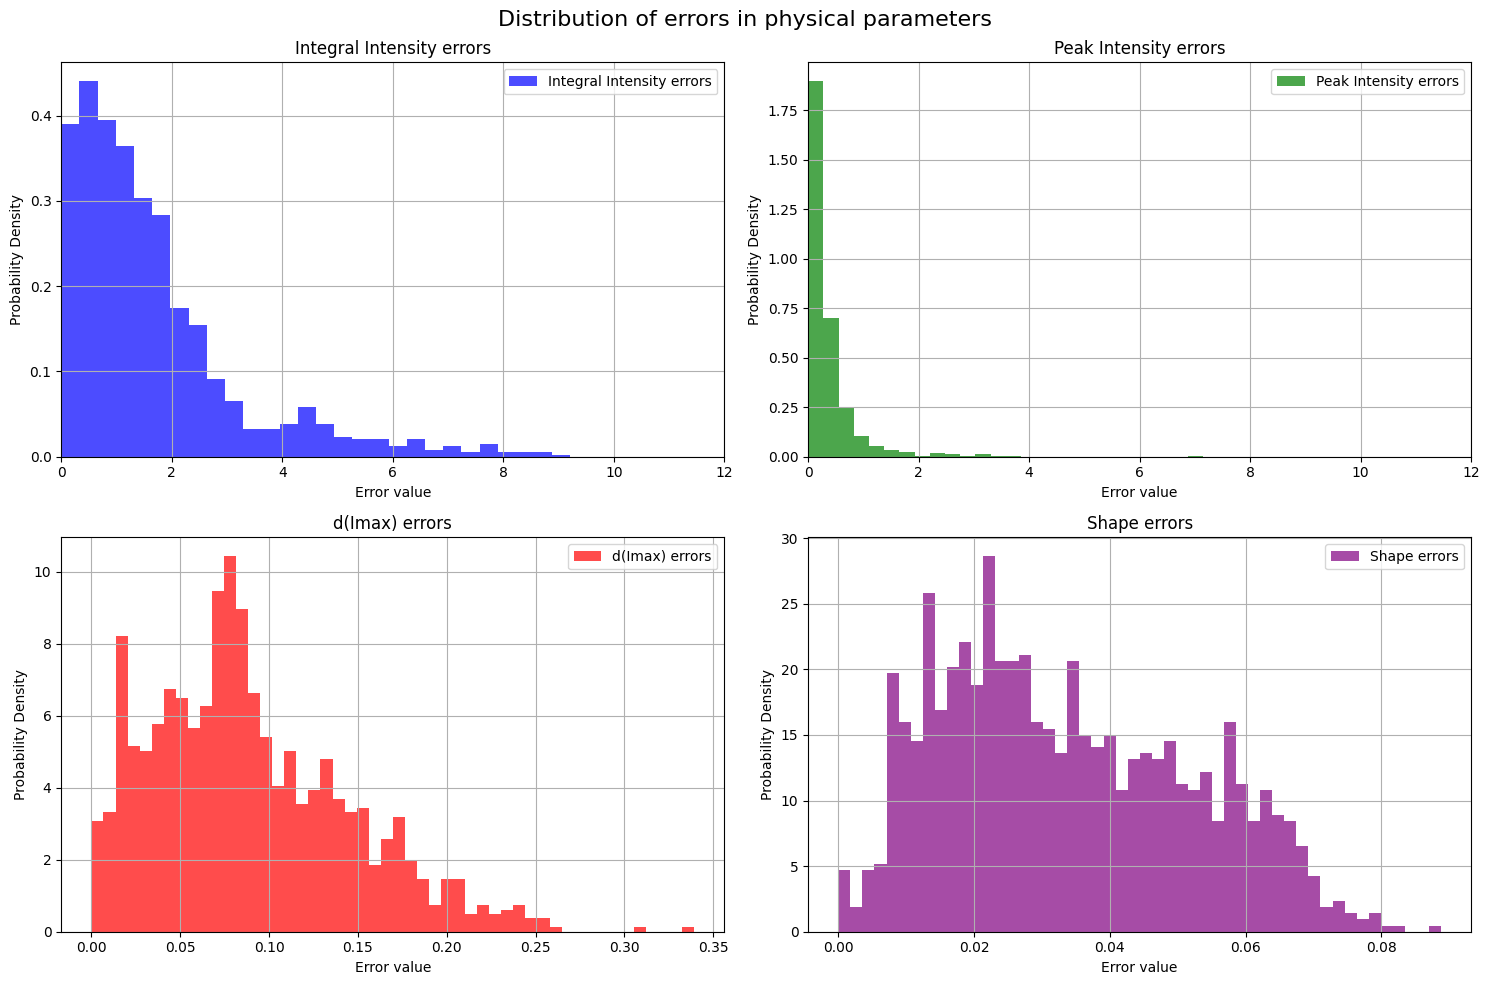

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что массивы уже созданы
# Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses

# Создаем фигуру с 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of errors in physical parameters', fontsize=16)

# Список массивов данных
data_arrays = [Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses]
titles = [
    "Integral Intensity errors",
    "Peak Intensity errors", 
    "d(Imax) errors",
    "Shape errors"
]
xlabels = ["Error value"] * 4
colors = ['blue', 'green', 'red', 'purple']  # Разные цвета для каждой гистограммы
bins = [300, 300, 50, 50]
limits = [[0, 12], [0, 12], None, None]

# Функция для построения одной гистограммы
def plot_histogram(ax, data, title, xlabel, color, bins, limits):
    ax.hist(data, alpha=0.7, bins=bins, density=True, color=color, label=title)
    if limits:
        ax.set_xlim(limits[0], limits[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Probability Density")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Построение всех 4 гистограмм
for i, ax in enumerate(axes.flat):
    plot_histogram(ax, data_arrays[i], titles[i], xlabels[i], colors[i], bins[i], limits[i])

plt.tight_layout()
plt.show()

In [ ]:
import json

with open("../results/SwinWnet_diffraction+error_matrix_physycal_metrics_extended.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "Integral Intensity losses": Integral_Intensity_losses,
            "Peak Intensity losses": Peak_Intensity_losses,
            "Shape_losses": Shape_losses
        },
        f,
        indent=4,
        ensure_ascii=False
    )

In [19]:
def normalize_piecewise(x, threshold=0.01, eps=1e-6):
    """
    x: [B, 1, H, W] tensor after convolution
    returns:
        x_norm: normalized tensor
        params: dict with all values needed for denormalization
    """
    # per-image min/max
    x_min = x.amin(dim=(2, 3), keepdim=True)
    x_max = x.amax(dim=(2, 3), keepdim=True)

    # scale to [0, 1]
    x01 = (x - x_min) / (x_max - x_min + eps)

    # piecewise: weak intensities linear, strong -> logarithmic compression
    mask = x01 > threshold

    # log transform only strong pixels
    x_strong = torch.log1p(x01) / torch.log1p(torch.tensor(1.0))

    # combine back
    x_norm = torch.where(mask, x_strong, x01)

    params = {
        'x_min': x_min,
        'x_max': x_max,
        'threshold': threshold
    }

    return x_norm, params

def denormalize_piecewise(x_norm, params, eps=1e-6):
    """
    x_norm: normalized output of upscaler
    params: dict returned by normalize_piecewise
    """
    x_min = params['x_min']
    x_max = params['x_max']
    threshold = params['threshold']

    # Split strong and weak regions
    mask = x_norm > threshold

    # inverse log for strong pixels
    x_strong = torch.expm1(x_norm)

    # combine back
    x01 = torch.where(mask, x_strong, x_norm)

    # rescale back to original dynamic range
    x = x01 * (x_max - x_min + eps) + x_min
    return x


In [ ]:
import torch
from tqdm import tqdm

# Validation
model_single.eval()
Integral_Intensity_losses = []
Peak_Intensity_losses = []
d_losses = []
Shape_losses = []

num_val_iterations = 5
with torch.no_grad():
    for _ in range(num_val_iterations):
        for hr, _ in tqdm(test_loader):
            hr = hr.to(device)

            mu = 100
            sigma = 0.2*mu
            
            # Создаем шум на том же устройстве
            noise = torch.randn_like(hr, device=device) * sigma + mu
            hr = hr + noise

            with torch.cuda.amp.autocast():
                # ===== ODD BATCH =====
                seg, skips_seg = model_single.segment_1(hr)

                # prepare data for SR
                seg = torch.sigmoid(seg)
                hr = seg * hr

                lr = F.interpolate(
                    hr, 
                    scale_factor=0.5, 
                    mode='bilinear', 
                    align_corners=False
                )  # размер: [32, 1, 125, 240]

                norm_lr, params_lr = normalize_piecewise(lr)
                denorm_lr = denormalize_piecewise(norm_lr, params_lr)

                norm_hr, params_hr = normalize_piecewise(hr)
                denorm_hr = denormalize_piecewise(norm_hr, params_hr)

                # SR @ full scale
                sr_out, _ = model_single.upscale(norm_lr.to(device), skips_seg)
                denorm_pred = denormalize_piecewise(sr_out, params_hr)

                for i, _ in enumerate(zip(norm_hr, sr_out)):


                    loss_peaks = pipe(
                        batch_pred_2d=denorm_pred[i][0].unsqueeze(0).unsqueeze(0),     # предсказанная 2D дифракция
                        batch_true_2d=lr[i][0].unsqueeze(0).unsqueeze(0),     # ground-truth 2D
                        peak_params_pred={"scale": True},
                        peak_params_true={"scale": False},
                        tol=0.05
                    )

                    Integral_Intensity_losses.append(loss_peaks['Integral Intensity'])
                    Peak_Intensity_losses.append(loss_peaks['Peak Intensity'])
                    d_losses.append(loss_peaks['d(Imax)'])
                    Shape_losses.append(loss_peaks['Shape'])

100%|██████████| 80/80 [00:06<00:00, 12.76it/s]


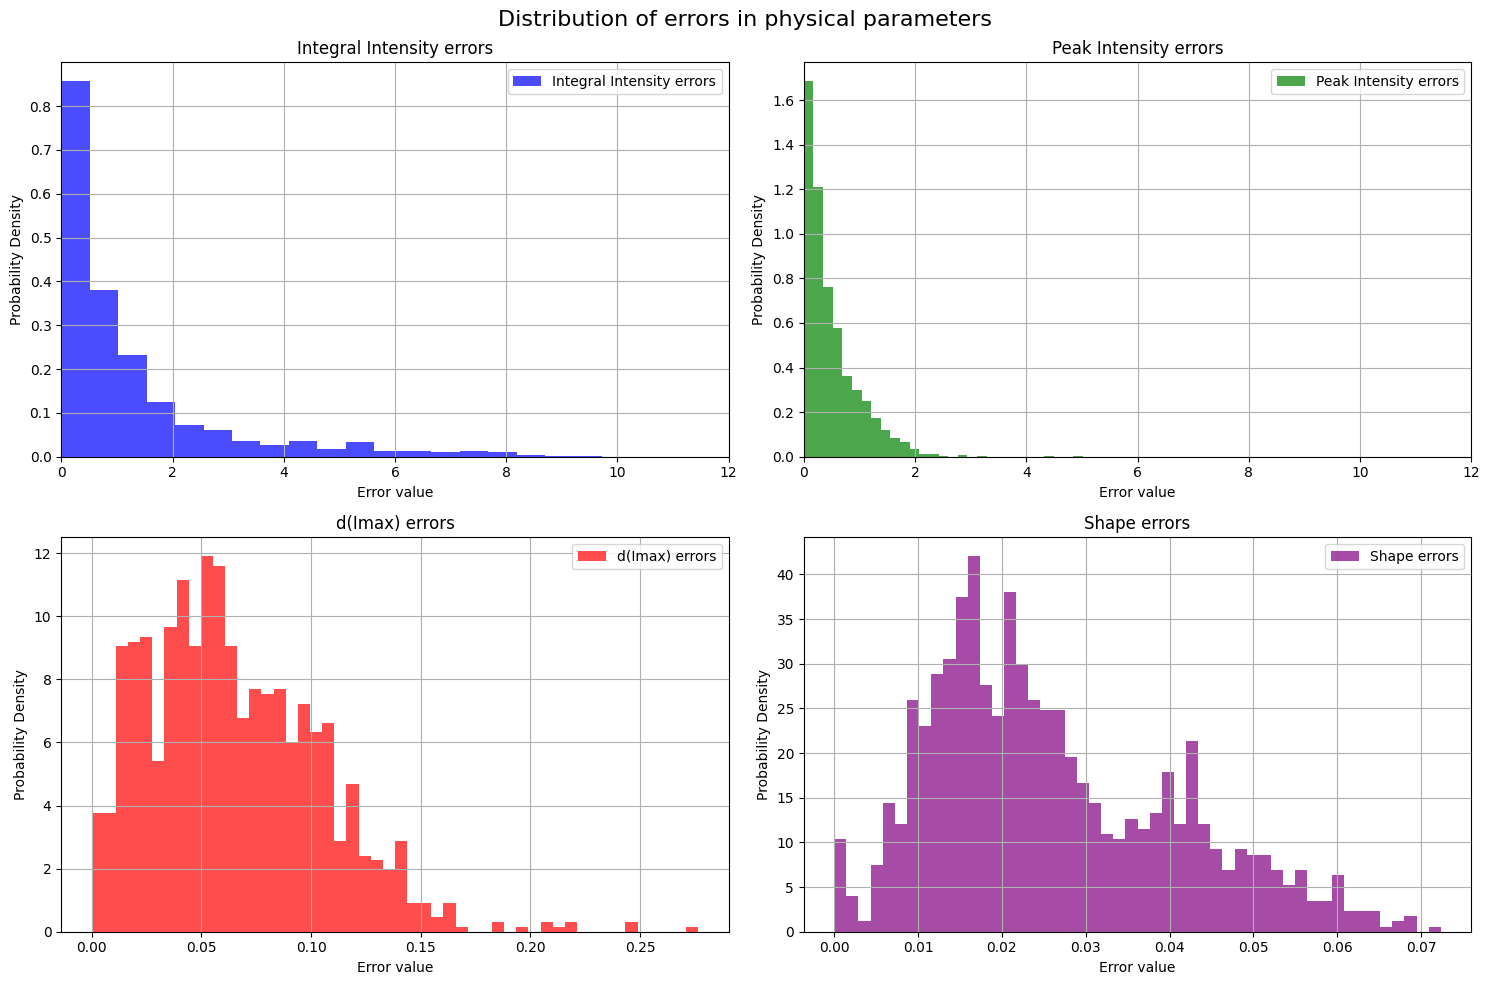

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что массивы уже созданы
# Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses

# Создаем фигуру с 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of errors in physical parameters', fontsize=16)

# Список массивов данных
data_arrays = [Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses]
titles = [
    "Integral Intensity errors",
    "Peak Intensity errors", 
    "d(Imax) errors",
    "Shape errors"
]
xlabels = ["Error value"] * 4
colors = ['blue', 'green', 'red', 'purple']  # Разные цвета для каждой гистограммы
bins = [300, 300, 50, 50]
limits = [[0, 12], [0, 12], None, None]

# Функция для построения одной гистограммы
def plot_histogram(ax, data, title, xlabel, color, bins, limits):
    ax.hist(data, alpha=0.7, bins=bins, density=True, color=color, label=title)
    if limits:
        ax.set_xlim(limits[0], limits[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Probability Density")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Построение всех 4 гистограмм
for i, ax in enumerate(axes.flat):
    plot_histogram(ax, data_arrays[i], titles[i], xlabels[i], colors[i], bins[i], limits[i])

plt.tight_layout()
plt.show()

In [ ]:
import json

with open("../results/SwinWnet_diffraction_physycal_metrics_extended.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "Integral Intensity losses": Integral_Intensity_losses,
            "Peak Intensity losses": Peak_Intensity_losses,
            "Shape_losses": Shape_losses
        },
        f,
        indent=4,
        ensure_ascii=False
    )

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

pool = nn.MaxPool2d(kernel_size=2, stride=2).to(device)

# Validation
model.eval()
Integral_Intensity_losses = []
Peak_Intensity_losses = []
d_losses = []
Shape_losses = []

num_val_iterations = 5
with torch.no_grad():
    for _ in range(num_val_iterations):
        for hr, _ in tqdm(test_loader):
            hr = hr.to(device)

            mu = 100
            sigma = 0.2*mu
            
            # Создаем шум на том же устройстве
            noise = torch.randn_like(hr, device=device) * sigma + mu
            hr = hr + noise

            error_matrix = torch.sqrt(torch.abs(hr))  # матрица ошибок
            hr = torch.cat([hr, error_matrix], dim=1)  # [8, 2, 250, 480]

            with torch.cuda.amp.autocast():
                # ===== ODD BATCH =====
                seg, skips_seg = model.segment_1(hr)

                # prepare data for SR
                seg = torch.sigmoid(seg)
                hr = hr * seg

                lr = pool(hr)

                norm_lr, params_lr = normalize_piecewise_multi_channel_vectorized(lr)
                denorm_lr = denormalize_piecewise_multi_channel_vectorized(norm_lr, params_lr)

                norm_hr, params_hr = normalize_piecewise_multi_channel_vectorized(hr)
                denorm_hr = denormalize_piecewise_multi_channel_vectorized(norm_hr, params_hr)

                # SR @ full scale
                sr_out = F.interpolate(
                    norm_lr, 
                    scale_factor=2.0, 
                    mode='bilinear', 
                    align_corners=False
                )

                denorm_pred = denormalize_piecewise_multi_channel_vectorized(sr_out, params_hr)

                for i, _ in enumerate(zip(norm_hr, sr_out)):


                    loss_peaks = pipe(
                        batch_pred_2d=denorm_pred[i][0].unsqueeze(0).unsqueeze(0),     # предсказанная 2D дифракция
                        batch_true_2d=lr[i][0].unsqueeze(0).unsqueeze(0),     # ground-truth 2D
                        peak_params_pred={"scale": True},
                        peak_params_true={"scale": False},
                        tol=0.05
                    )

                    Integral_Intensity_losses.append(loss_peaks['Integral Intensity'])
                    Peak_Intensity_losses.append(loss_peaks['Peak Intensity'])
                    d_losses.append(loss_peaks['d(Imax)'])
                    Shape_losses.append(loss_peaks['Shape'])

100%|██████████| 80/80 [00:03<00:00, 23.02it/s]


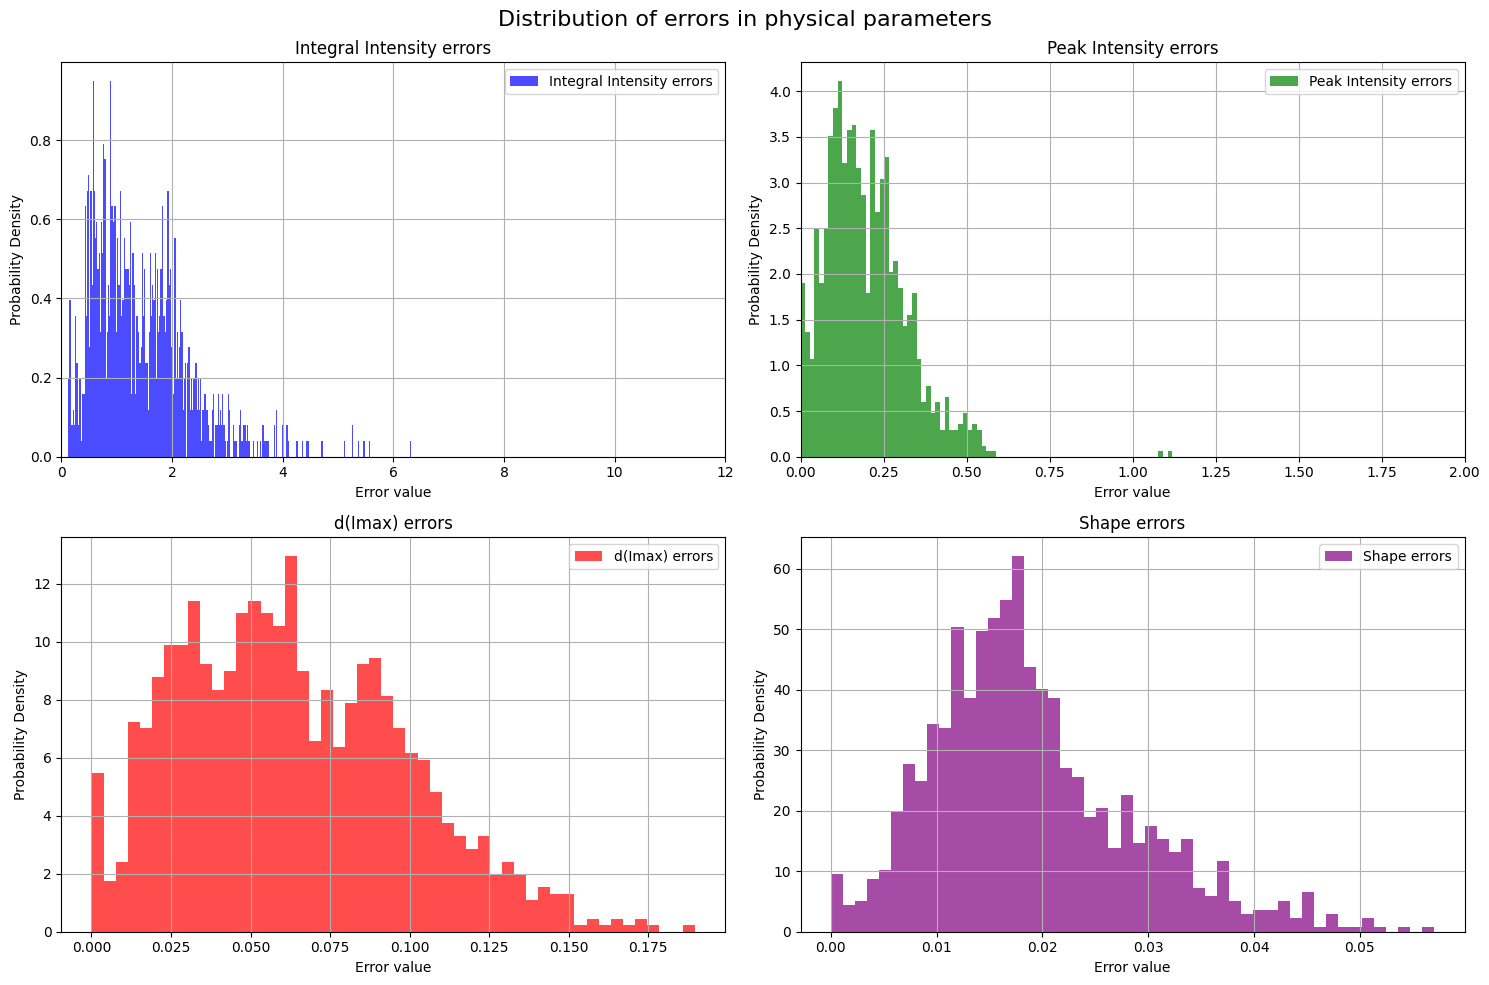

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что массивы уже созданы
# Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses

# Создаем фигуру с 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of errors in physical parameters', fontsize=16)

# Список массивов данных
data_arrays = [Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses]
titles = [
    "Integral Intensity errors",
    "Peak Intensity errors", 
    "d(Imax) errors",
    "Shape errors"
]
xlabels = ["Error value"] * 4
colors = ['blue', 'green', 'red', 'purple']  # Разные цвета для каждой гистограммы
bins = [300, 80, 50, 50]
limits = [[0, 12], [0, 2], None, None]

# Функция для построения одной гистограммы
def plot_histogram(ax, data, title, xlabel, color, bins, limits):
    ax.hist(data, alpha=0.7, bins=bins, density=True, color=color, label=title)
    if limits:
        ax.set_xlim(limits[0], limits[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Probability Density")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Построение всех 4 гистограмм
for i, ax in enumerate(axes.flat):
    plot_histogram(ax, data_arrays[i], titles[i], xlabels[i], colors[i], bins[i], limits[i])

plt.tight_layout()
plt.show()

In [ ]:
import json

with open("../results/BilinearInterpolation_diffraction_physycal_metrics_extended.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "Integral Intensity losses": Integral_Intensity_losses,
            "Peak Intensity losses": Peak_Intensity_losses,
            "Shape_losses": Shape_losses
        },
        f,
        indent=4,
        ensure_ascii=False
    )

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

pool = nn.MaxPool2d(kernel_size=2, stride=2).to(device)

# Validation
model.eval()
Integral_Intensity_losses = []
Peak_Intensity_losses = []
d_losses = []
Shape_losses = []

num_val_iterations = 5
with torch.no_grad():
    for _ in range(num_val_iterations):
        for hr, _ in tqdm(test_loader):
            hr = hr.to(device)

            mu = 100
            sigma = 0.2*mu
            
            # Создаем шум на том же устройстве
            noise = torch.randn_like(hr, device=device) * sigma + mu
            hr = hr + noise

            error_matrix = torch.sqrt(torch.abs(hr))  # матрица ошибок
            hr = torch.cat([hr, error_matrix], dim=1)  # [8, 2, 250, 480]

            with torch.cuda.amp.autocast():
                # ===== ODD BATCH =====
                seg, skips_seg = model.segment_1(hr)

                # prepare data for SR
                seg = torch.sigmoid(seg)
                hr = hr * seg

                lr = pool(hr)

                for i, _ in enumerate(zip(norm_hr, sr_out)):


                    loss_peaks = pipe(
                        batch_pred_2d=hr[i][0].unsqueeze(0).unsqueeze(0),     # предсказанная 2D дифракция
                        batch_true_2d=lr[i][0].unsqueeze(0).unsqueeze(0),     # ground-truth 2D
                        peak_params_pred={"scale": True},
                        peak_params_true={"scale": False},
                        tol=0.05
                    )

                    Integral_Intensity_losses.append(loss_peaks['Integral Intensity'])
                    Peak_Intensity_losses.append(loss_peaks['Peak Intensity'])
                    d_losses.append(loss_peaks['d(Imax)'])
                    Shape_losses.append(loss_peaks['Shape'])

100%|██████████| 80/80 [00:03<00:00, 23.29it/s]


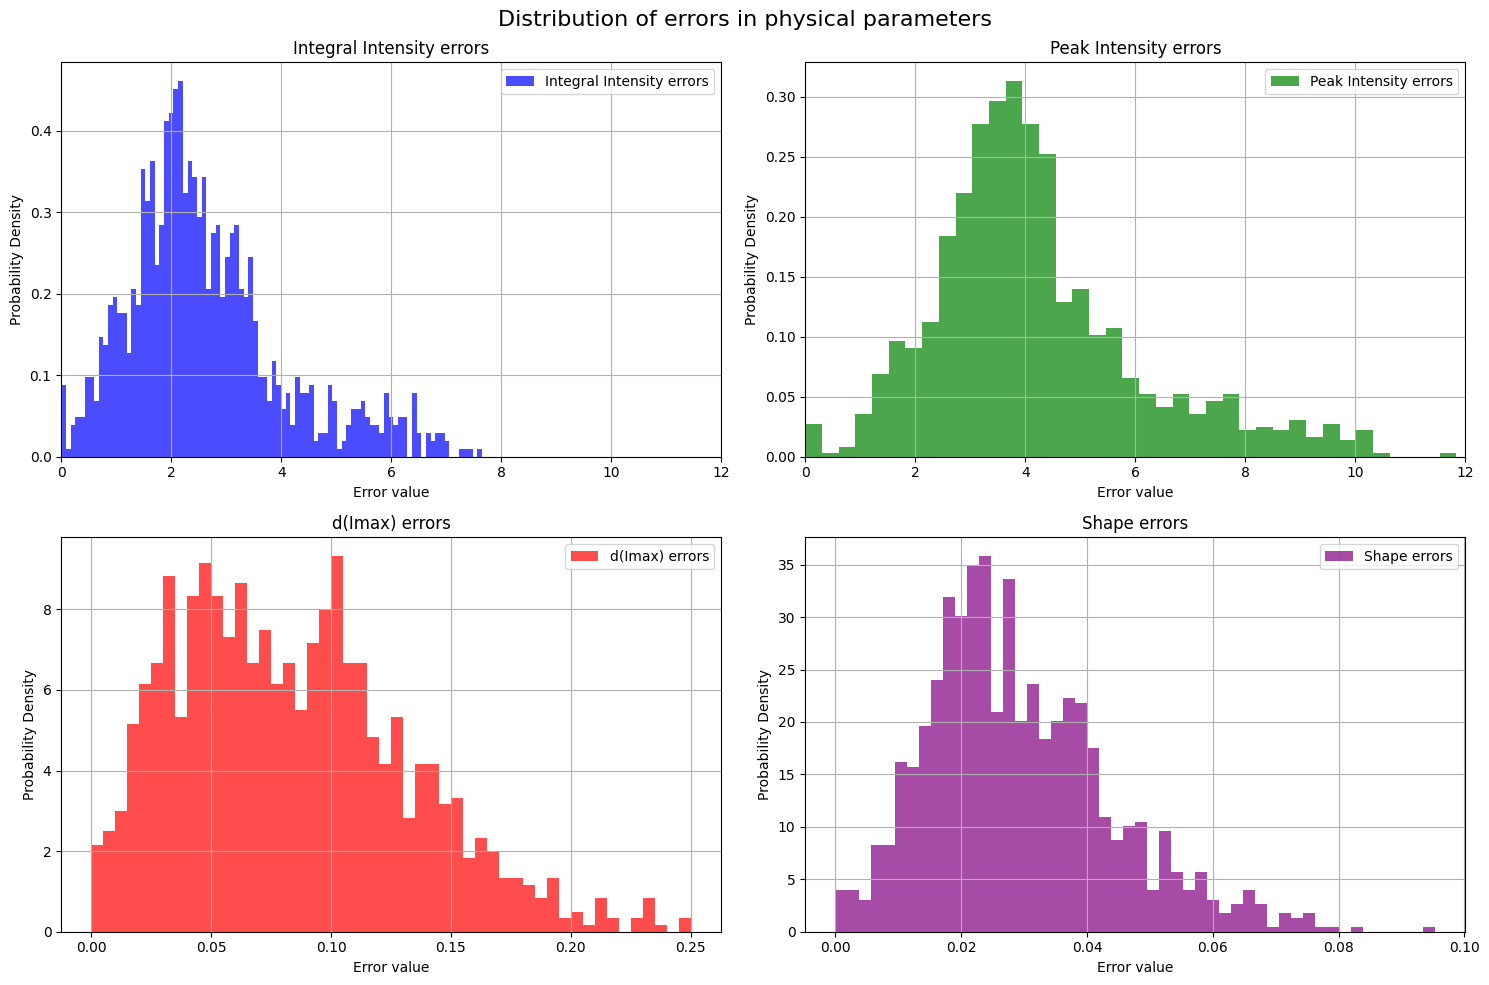

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что массивы уже созданы
# Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses

# Создаем фигуру с 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of errors in physical parameters', fontsize=16)

# Список массивов данных
data_arrays = [Integral_Intensity_losses, Peak_Intensity_losses, d_losses, Shape_losses]
titles = [
    "Integral Intensity errors",
    "Peak Intensity errors", 
    "d(Imax) errors",
    "Shape errors"
]
xlabels = ["Error value"] * 4
colors = ['blue', 'green', 'red', 'purple']  # Разные цвета для каждой гистограммы
bins = [150, 200, 50, 50]
limits = [[0, 12], [0, 12], None, None]

# Функция для построения одной гистограммы
def plot_histogram(ax, data, title, xlabel, color, bins, limits):
    ax.hist(data, alpha=0.7, bins=bins, density=True, color=color, label=title)
    if limits:
        ax.set_xlim(limits[0], limits[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Probability Density")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Построение всех 4 гистограмм
for i, ax in enumerate(axes.flat):
    plot_histogram(ax, data_arrays[i], titles[i], xlabels[i], colors[i], bins[i], limits[i])

plt.tight_layout()
plt.show()

In [ ]:
import json

with open("../results/AVGPoolin_diffraction_physycal_metrics_extended.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "Integral Intensity losses": Integral_Intensity_losses,
            "Peak Intensity losses": Peak_Intensity_losses,
            "Shape_losses": Shape_losses
        },
        f,
        indent=4,
        ensure_ascii=False
    )

In [1]:
import torch
import torch.nn as nn

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm_q = nn.LayerNorm(dim)
        self.norm_kv = nn.LayerNorm(dim)

        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=num_heads,
            batch_first=True
        )

        self.gamma = nn.Parameter(torch.zeros(1))  # 🔥 ключ

    def forward(self, q, kv):
        qn = self.norm_q(q)
        kvn = self.norm_kv(kv)

        attn_out, _ = self.attn(qn, kvn, kvn)
        return q + self.gamma * attn_out

class MultiScaleCrossAttention(nn.Module):
    def __init__(self, dims, heads):
        super().__init__()
        self.blocks = nn.ModuleList([
            CrossAttentionBlock(d, h)
            for d, h in zip(dims, heads)
        ])

    def forward(self, target_skips, source_skips):
        out = []
        for blk, t, s in zip(self.blocks, target_skips, source_skips):
            out.append(blk(t, s))
        return out

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# torch.Size([2, 7560, 48]) (63, 120)
# torch.Size([2, 1920, 96]) (32, 60)
# torch.Size([2, 480, 192]) (16, 30)
# torch.Size([2, 120, 384]) (8, 15)

# torch.Size([2, 30000, 48]) (125, 240)
# torch.Size([2, 7560, 96]) (63, 120)
# torch.Size([2, 1920, 192]) (32, 60)
# torch.Size([2, 480, 384]) (16, 30)

dims  = [192, 384]
heads = [3, 3]


skips1 = [torch.randn(2, 1920, 192).to(device), torch.randn(2, 480, 384).to(device)]
skips2 = [torch.randn(2, 1920, 192).to(device), torch.randn(2, 480, 384).to(device)]
skips3 = [torch.randn(2, 480, 192).to(device), torch.randn(2, 120, 384).to(device)]

msca = MultiScaleCrossAttention(dims=dims, 
                                heads=heads).to(device)

with torch.no_grad():
    out = msca(skips2, skips3) # target_skips, source_skips

for tensor in out:
    print(tensor.size())

torch.Size([2, 1920, 192])
torch.Size([2, 480, 384])
